# Using Cardiac Factors To Predict Whether Individuals Will Experience Heart Failure
#### Harsh A, Kyle M, Daniel L, Catarina A 

### Introduction
Cardiovascular diseases and heart failure account for the greatest amount of deaths per year globally, accounting for approximately a third of the global annual deaths. The main causes leading to heart failure are often associated with increased blood pressure (hypertension) and closing of the arteries (build-up of cholesterol and fats), both of which are indicated by an individual's maximum heart rate and are often associated with aging.

**Significance:**
Machine learning models can play an important role in the early detection of cardiovascular diseases. Through comparing data from past patients with similar symptoms the model should be capable of creating a relatively accurate prediction of the patient's heart disease diagnosis. Therefore, the patient should be able to get early treatment, preventing further complications and improving the patient's health. This tool would be of great use in medical facilities, if correctly refined and developed, machine learning models could possibly be implemented in hospitals, changing and improving our understanding and management of diseases. 

**Our Main Goal:**
In this context, our project’s main goal is to use the dataset *Heart Failure Prediction Dataset* by Fedesoriano, originally sourced from the UCI database, to successfully create a somewhat accurate model to diagnose whether an individual has heart disease and will experience heart failure. The dataset chosen includes data from various heart disease patients and was created by combining other datasets,  which makes it the largest heart disease dataset available and will greatly aid our predictions. The dataset contains four demographics worth of data which ensures that this model can be versatile and applicable to multiple demographics of data. Specifically, Cleveland, Hungary, Switzerland, and Long Beach were the demographics mentioned in this dataset. Furthermore, this gives us a total of 747 observations, since we removed 171 duplicate observations, which we will use to solve our main question.

**Question:** Can we predict whether a patient will experience heart failure (caused by heart disease) based on their age, resting blood pressure, cholesterol, and maximum heart rate?

### Expected Outcome
**Expectations:**
We expect to find that older individuals with increased resting blood pressure, increased cholesterol levels, and decreased maximum heart rate will experience heart failure in their lifetimes.

### Methods
#### Preliminary Exploratory Data Analysis
1. Import all required libraries and the data set from public GitHub repository.

2. Clean data into a tidy format for data analysis and readability.

3. Split data into training and testing data using `initial_split` with a 0.75 split ratio around our categorical variable `heart_failure` by feeding it into `strata`.

4. Summarize the training data in one table in order to ensure the data has no bias towards one category and compare values of predictors.

5. Visualize the distribution and relationships between age, resting blood pressure, cholesterol and max heart rate in order to confirm a relationship between all predictors.

#### Building The Classification Model
**First we need to find the k value which will provide the highest accuracy for our model:**

1. Create a recipe around the heart_failure category and include all predictors previously discussed, ensure all predictors and scaled and centered.

2. Create a tuning knn classification spec using the `nearest_neighbor` function and set `neighbors` equal to `tune()`.

3. Perform a 5 fold cross validation on the training data (v = 5) using `vfold_cv`.

4. Create a workflow analysis by adding the recipe from step 1 and the model from step 2, then use `tune_grid` to fit the resamples from our cross validation and use `gridvals` to check the accuracy for every k value from 1 to 100 in order to ensure all cases are plausible k values are checked for.

5. Collect metrics using `collect_metrics` from the workflow analysis and `pull` the optimal k value by arranging in descending order and slicing the neighbors value from the 1 row tibble using `slice_head`.

6. Create a k vs accuracy plot in order to confirm the optimal k value's accuracy is the highest.

**We then need to build our final model using this optimal k value:**

7. Create a new knn classification using the `nearest_neighbor` function and set neighbors equal to the optimal k we just found.

8. Using a workflow add the original recipe, the new optimal knn spec, and `fit` it to the training data.

#### Testing and Analysis

1. Use the `predict` function to test our new model on the testing data.

2. Collect metrics and `filter` for accuracy to display the accuracy of our newly built model.

3. Analyze the confusion matrix of our model's prediction using `conf_mat`.

4. Make final visualizations for model analysis.



### Preliminary Exploratory Data Analysis

Importing all required libraries and install knn package in case notebook doesn't contain knn package required to create the model.

In [60]:
install.packages("cowplot") #installing packages because UBC Jupyter Lab didn't have them pre-installed
install.packages("kknn") 
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(shiny)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



The data set couldn't be read directly from the kaggle set it was initially sourced from, however, we were able to move the data set to our public GitHub repository and read the data in from the web using `read_csv` from the raw data source from the repository. 

In [61]:
#loading raw dataset with new clean column names

heart_raw <- read_csv("https://raw.githubusercontent.com/hamin2006/Group_Project_7/main/data/heart1.csv",  
                       skip = 1, 
                       col_names = c("age","sex","chest_pain","resting_bp","cholesterol","fasting_bs","rest_ecg",
                                    "max_heart_rate","excercise_angina","old_peak","st_slope","heart_failure")) 


Rows: 746 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sex, chest_pain, rest_ecg, excercise_angina, st_slope
dbl (7): age, resting_bp, cholesterol, fasting_bs, max_heart_rate, old_peak,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We now need to clean the data and increase readability using `fct_recode`, then choose and select all predictor variables. We also need to set our categorical value as a factor using `as_factor` and update the category from binary interpretation to more clear classifications.

**Choosing Variables:** To choose our variables for prediction we turned to the Centers for Disease Control and Prevention which stated that high blood pressure and cholesterol are the main factors which cause heart disease and failure. Furthermore, we determined that low maximum heart rate is an indicator of high blood pressure (stated by the National Library of Medicine) and is often related to aging, giving us our 4 predictor variables whose same trends should be visible in scatter plots.

In [62]:
set.seed(100)

#cleaning data and selecting predictor variables
heart_data <- heart_raw |>
    mutate(heart_failure = as_factor(heart_failure),
           heart_failure = fct_recode(heart_failure, "Healthy" = "0", "Unhealthy" = "1")) |> 
    select(age, resting_bp, cholesterol, max_heart_rate, heart_failure) 


In order to successfully build and test our model we first need to split the data into training and testing sets. We will do this by using `intial_split` to split the data set into 75% training data and 25% testing data around our stratified categorical variable `heart_failure` to ensure an equal ratio of each classification is in each subset.

In [63]:
#splitting clean data into training and testing sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_failure)

heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_training

age,resting_bp,cholesterol,max_heart_rate,heart_failure
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,Healthy
37,130,283,98,Healthy
54,150,195,122,Healthy
⋮,⋮,⋮,⋮,⋮
68,144,193,141,Unhealthy
57,130,131,115,Unhealthy
57,130,236,174,Unhealthy


*Table 1: Sample training data*

Using the training data from Table 1, we'll now summarize the `heart_failure` variable and all predictor variables in order to:
* Ensure that `heart_failure` has a even and equal spread across the subset of training data.
* Ensure that the data doesn't cause our model to be biased towards one classification.
* Distinguish trends amongst individual variables.
* Ensure there's no missing data.

To make this summarization table we will calculate the number of patients classified to Healthy and Unhealthy heart status and their respective percentages considering the entire training dataset, and take the means of each predictor variable for Healthy and Unhealthy patients.

In [64]:
#summarization of training data
heart_training_summary <- heart_training |>
    group_by(heart_failure) |>
    summarize (patients = n(),
               percentage = round(n() / nrow(heart_training) * 100, 0),
              mean_age = mean(age),
              mean_resting_bp = mean(resting_bp),
              mean_cholesterol = mean(cholesterol),
              mean_max_heart_rate = mean(max_heart_rate),
              missing_data = sum(is.na(age)) + sum(is.na(resting_bp)) + sum(is.na(cholesterol)) + sum(is.na(max_heart_rate)) + sum(is.na(heart_failure)))

heart_training_summary

heart_failure,patients,percentage,mean_age,mean_resting_bp,mean_cholesterol,mean_max_heart_rate,missing_data
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Healthy,292,52,50.31849,130.3733,238.6644,148.9418,0
Unhealthy,267,48,55.46067,136.6779,252.9775,130.0112,0


*Table 2: Summary of each classification's predictor values*

From table 2 we can see that we have a very even split of our categorical values, this will ensure that our classification model won't favour the classification of one category over another due to there not being enough observations of each category. This equivalent ratio of healthy to unhealthy patients will ensure that our model's classification will be mainly based off of the trends we see in the predictor variables and not biased data.

Furthermore, we can distinguish some trends between the classifications and their predictors:

**Healthy** individuals are more likely to be younger, with a lower resting blood pressure, lower cholesterol, and higher max heart rate.

**Unhealthy** individuals who have been classified with heart disease are, on average, older, with a higher resting blood pressure, higher cholesterol, and lower max heart rate.

These trends should also be apparent if we were visualize the data in order to confirm these trends within our predictors as we will below.

To make these visualizations we will plot our predictors amongst each other and `colour` by `heart_failure` to distinguish the trends we can see between the data and their relationship with our categorical variable.

In [65]:
options(repr.plot.height = 6, repr.plot.width = 6)
plot1 <- ggplot(heart_training, aes(x = age, y = resting_bp, colour = heart_failure)) +
                geom_point() +
                labs(x = "Age (years)", y = "Resting Systolic Blood Pressure (mm Hg)", 
                     colour = "Heart Health",
                     title = "Figure 3: Scatter plot of patient age and their resting systolic blood pressure")

plot2 <- ggplot(heart_training, aes(x = age, y = max_heart_rate, colour = heart_failure)) +
                geom_point() +
                labs(x = "Age (years)", y = "Maximum Patient Heart Rate (BPM)", 
                     colour = "Heart Health",
                     title = "Figure 1: Scatter plot of patient age and their maximum heart rate")

plot3 <- ggplot(heart_training, aes(y = cholesterol, x = max_heart_rate, colour = heart_failure)) +
                geom_point() +
                labs(y = "Serum Cholesterol (mg/dL)", x = "Maximum Patient Heart Rate (BPM)",
                     colour = "Heart Health",
                     title = "Figure 2: Scatter plot of patient serum cholesterol levels and max heart rate") +
                ylim(c(80,420))


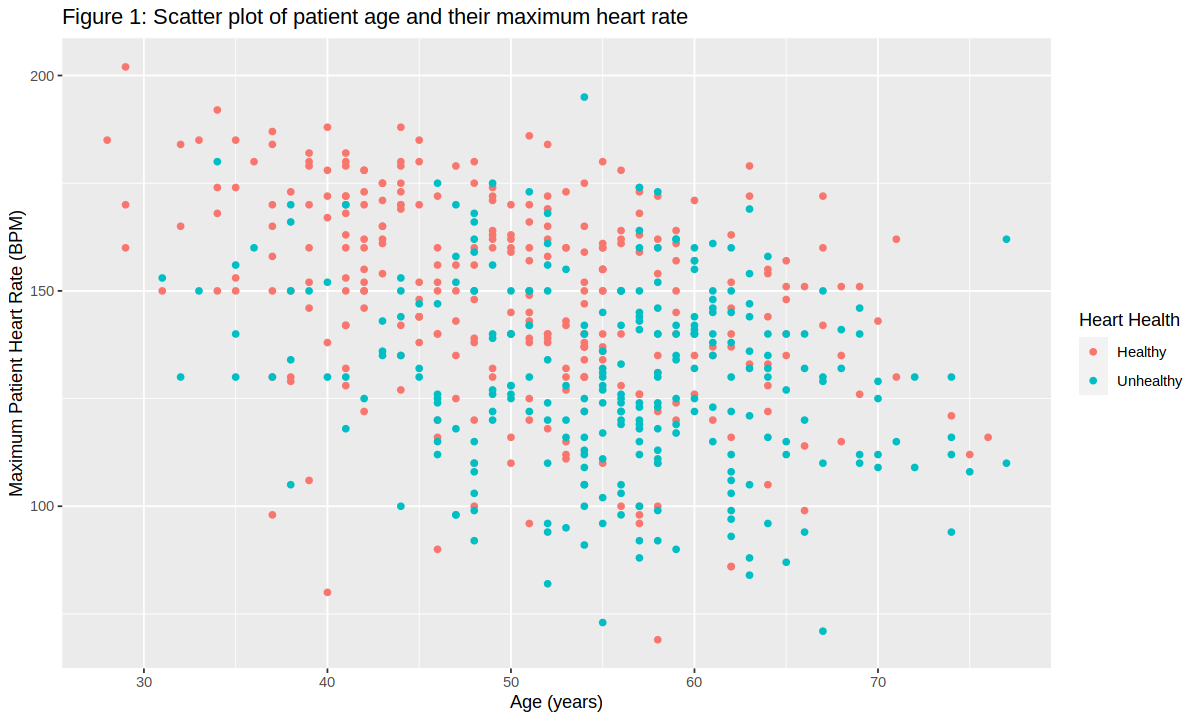

In [66]:
options(repr.plot.height = 6, repr.plot.width = 10)
plot2

Evidently, figure 1 expresses a slightly negative relationship between max heart rate and age. As Age increases, we see an individual's max heart rate decrease. We can also see an increase in heart disease diagnosed individuals to the right of the graph where older individuals with lower heart rates are plotted. These trends perfectly coincide with the trends we distinguished from our summarization table in figure 2.

Warning message:
“Removed 7 rows containing missing values (`geom_point()`).”


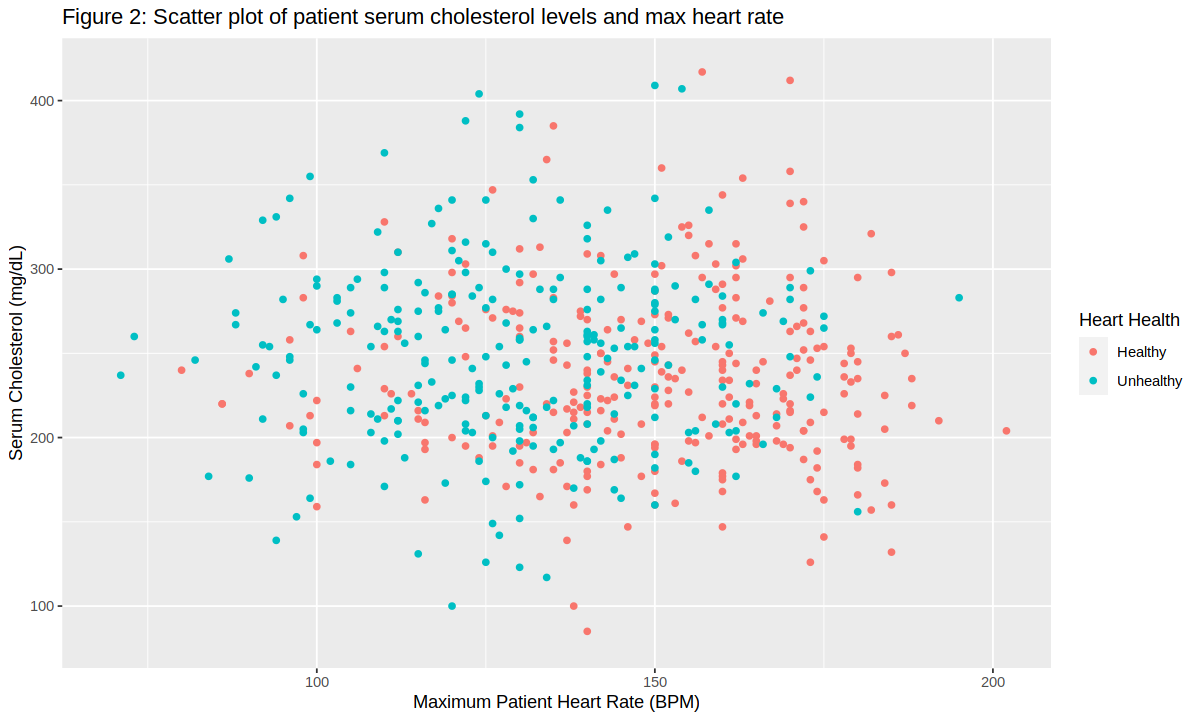

In [67]:
plot3

In the Figure 2 plot above it's difficult to distinguish a trend between a patient's BPM and cholesterol, however, we can see a very slight negative relationship, which can be interpreted by saying as a patient's max heart rate increases their cholesterol coincidentally decreases. What we can evidently distinguish from this graph is a concentration of healthy patient's towards the right side of the graph and more unhealthy patient's to the left side of the graph. This means that patients with heart disease most likely have lower max heart rate's and increased cholesterol while the opposite would exist for healthy patients.

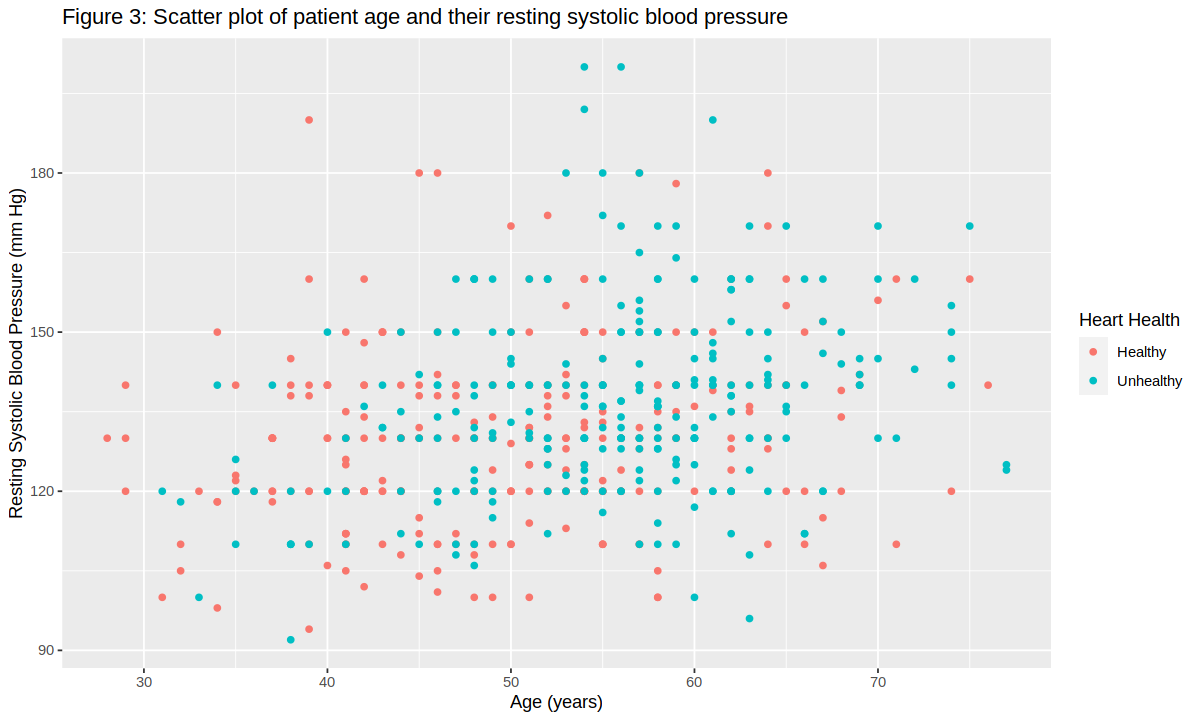

In [68]:
plot1

In this scatter plot we can see a slightly positive relationship between the age and resting systolic blood pressure of a patient. This can be interpreted by saying the older a patient gets the higher their resting systolic blood pressure becomes. We can also see a congregation of patients with heart disease shifted towards the top right of the graph. This translates to heart disease patients on average being older and having a higher resting systolic blood pressure. Healthy patients on the other hand are more likely to be younger and have a lower resting systolic blood pressure. We can also now confirm that all of our predictors show some sort of trend among each other and around or heart failure variable.

### Building The Classification Model

Now that we have visualized and confirmed the predictors that we're going to use to classify patients we can create our classification model using the training data set we have made and the predictors we have confirmed.

The first step is to create our `recipe` using all of the predictors we have selected in our training data. We have to ensure we also center and scale the predictors in order to ensure all predictors are weighted equally in the euclidean distance formula.

In [69]:
set.seed(20)
heart_recipe <- recipe(heart_failure ~. , data = heart_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Centering for all_predictors()
Scaling for all_predictors()

Now that our recipe is made for 1 classification variable and 4 predictor variables the next step in building our model is to find the number of neighbors (k) which will give us the highest prediction accuracy. First we will use the `nearest_neighbor` function to build a tuning classification knn spec by using `neighbors = tune()`.

In [70]:
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn") |>
    set_mode("classification")

We now have to use `vfold_cv` to perform a 5 fold cross validation on the training data and create a workflow analysis by adding the recipe and the classification spec we just made, then use `tune_grid` to fit the resamples from our cross validation and use grid to check the accuracy for every k value from 1 to 100 in order to ensure all cases of plausible k values are checked for. Any k value above 100 may be more accurate but would take too long to process and make an inefficient model therefore we will stick to a k value which is under 100 neighbors.

In [71]:
heart_vfold <- vfold_cv(heart_training, v = 5, strata = heart_failure) #5 fold cross validation 

heart_workflow <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = tibble(neighbors = c(1:100))) #perform cross validation for all k between 1 and 100

Now that our workflow is made we can collect metrics for each k value using `collect_metrics`, filter for accuracy and arrange the table in descending order in terms of accuracy.

In [72]:
heart_metrics <- heart_workflow |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(-mean)

We can now isolate for the k value which gave us the highest accuracy from the cross validation using `slice_head` and pull the optimal and most accurate amount of neighbors.

In [73]:
optimal_accuracy <- heart_metrics |> #Accuracy of the most optimal k
    select(neighbors, mean) |>
    slice_head()
optimal_accuracy

optimal_k <- optimal_accuracy |> #pulling our optimal k value
    select(neighbors) |>
    pull()

neighbors,mean
<int>,<dbl>
85,0.7067368


*Table 3: The most accurate amount of neighbors and it's accuracy*

We can now create a k versus accuracy line graph using the `heart_metrics` we collected from the cross validation workflow analysis in order to confirm that the k value we pulled from the row in table 3 is the most accurate value given the results from the cross validation.

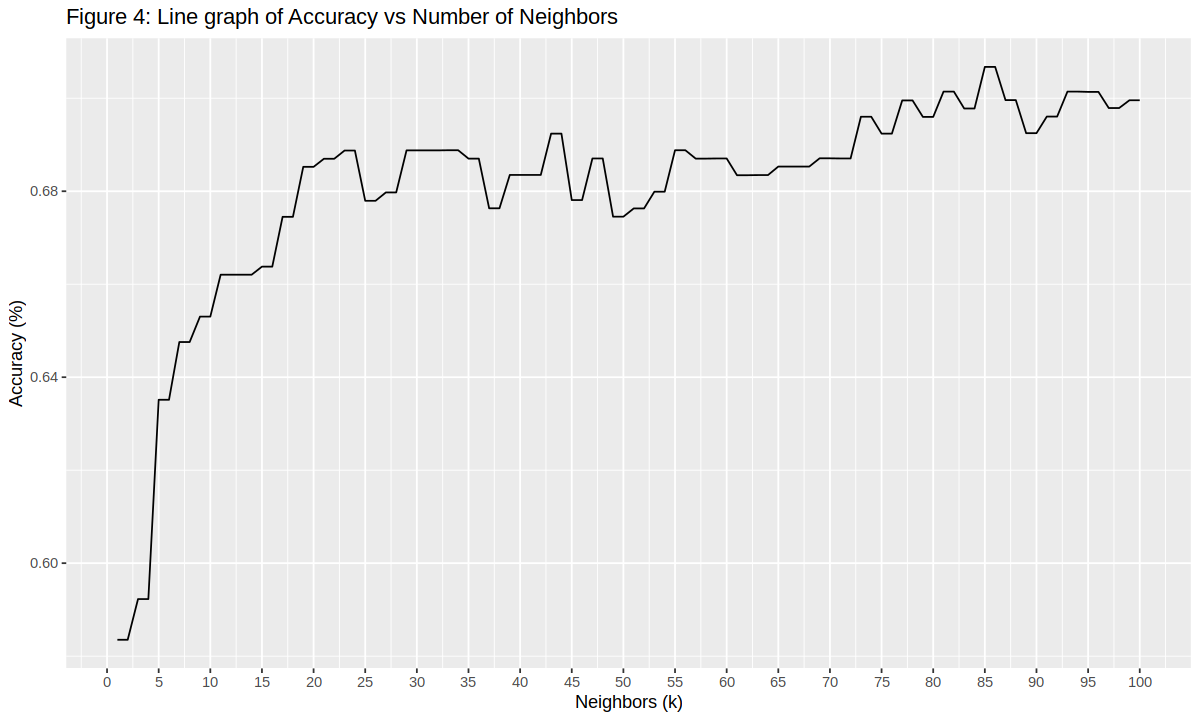

In [74]:
options(repr.plot.heigh = 8, repr.plot.width = 10)
plot_k <- heart_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_line() +
        labs(x = "Neighbors (k)", y = "Accuracy (%)", title = "Figure 4: Line graph of Accuracy vs Number of Neighbors") +
        scale_x_continuous(breaks = seq(0,100, by = 5))
plot_k

Looking at this figure 4 line graph we can ensure that 85 neighbors will give us the most accuracy when building our actual model. However, we also see that 86 neighbors gives us the same accuracy, but we will go with the lower amount of neighbors because it will take a smaller amount of time to process while producing the same accuracy.

Now that we have pulled the most optimal value for number of neighbors we can build our final model for classification.
* We have to create a new classification knn spec using the new `optimal_k` we just found.
* The last step would be to create a workflow using the original recipe, the new knn spec and fit the workflow to the training data.

In [75]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k)|>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_training)
heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(85L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.313059
Best kernel: rectangular
Best k: 85

### Testing and Analysis

We can now finally use the testing set to test the accuracy of our classification model. We can now use the `heart_fit` found previously and use the `predict` function to test on the `heart_testing` testing data and analyze the accuracy of our model and it's confusion matrix.

In [76]:
predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

metrics <- predictions |> 
    metrics(truth = heart_failure, estimate = .pred_class) |>
    filter(.metric == "accuracy")
metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7326203


*Table 4: Accuracy of the classification model on the testing data*

As we can see above from table 4 our classification model has a classification accuracy of 73.3%, but before making any inferences about the result we should use the confusion matrix in order to create a visualization which can express the results of our model.

In [77]:
conf_mat <- predictions |>
    conf_mat(truth = heart_failure, estimate = .pred_class)
conf_mat

           Truth
Prediction  Healthy Unhealthy
  Healthy        75        27
  Unhealthy      23        62

*Figure 5: Confusion matrix of our model's testing results*

We can see that the model is more likely to under-diagnose (27 incorrect Healthy patients) than over-diagnose (23 incorrect Unhealthy patients) which may be a redeeming quality in our model as it is somewhat more on the safe side of diagnosing because it's better to under-diagnose than over-diagnose because diagnosing a healthy person with heart disease could be detrimental regarding the unneeded treatment they would have to endure. As long as the model isn't the only factor considered in the diagnosis of a patient, under-diagnosis is not necessarily a bad thing. From the confusion matrix we have a total 102 predicted healthy patients and 85 predicted unhealthy patients. Let's make 2 bar plots to compare the model's results to the correct classification from the original testing data.

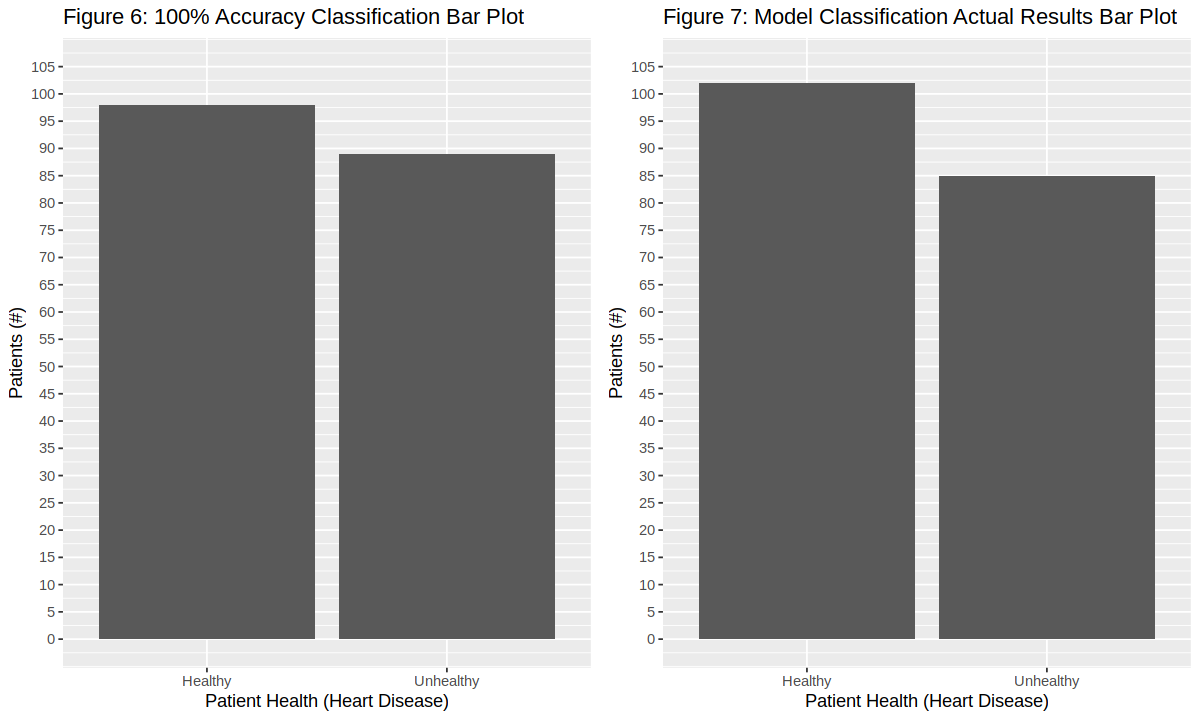

In [78]:
options(repr.plot.height = 6, repr.plot.width = 10)
expected_results <- ggplot(heart_testing, aes(x = heart_failure)) +
    geom_bar() +
    labs(x = "Patient Health (Heart Disease)", y = "Patients (#)", title = "Figure 6: 100% Accuracy Classification Bar Plot") +
    scale_y_continuous(breaks = seq(0,105, by = 5), limits = c(0,105))


true_healthy <- tibble(patient = c(1:75),
                         result = "Healthy",
                         classification = "Correct")
true_unhealthy <- tibble(patient = c(1:62),
                         result = "Unhealthy",
                         classification = "Correct")
false_healthy <- tibble(patient = c(1:27),
                         result = "Healthy",
                         classification = "Incorrect")
false_unhealthy <- tibble(patient = c(1:23),
                         result = "Unhealthy",
                         classification = "Incorrect")
                         
result_tibble <- bind_rows(true_healthy, true_unhealthy, false_healthy, false_unhealthy)

actual_results <- ggplot(result_tibble, aes(x = result)) +
    geom_bar() +
    labs(x = "Patient Health (Heart Disease)", y = "Patients (#)", title = "Figure 7: Model Classification Actual Results Bar Plot") +
    scale_y_continuous(breaks = seq(0,105, by = 5), limits = c(0,105))

comparison_plot <- plot_grid(expected_results, actual_results, ncol = 2)
comparison_plot


The figures above are meant to summarize our findings by comparing the split of the theoretical results of a 100% accurate model to the split of our actual results solved for by our classification model. Because the two graphs were plotted side by side and on the same scale we can see that the distribution of the data has only changed by a margin of less than 10 patients, however this graph can be misleading if we weren't considering the incorrectly classified patients from our results. Let's do this below using a ratio bar plot through a `position = "fill"` argument in `geom_bar`.

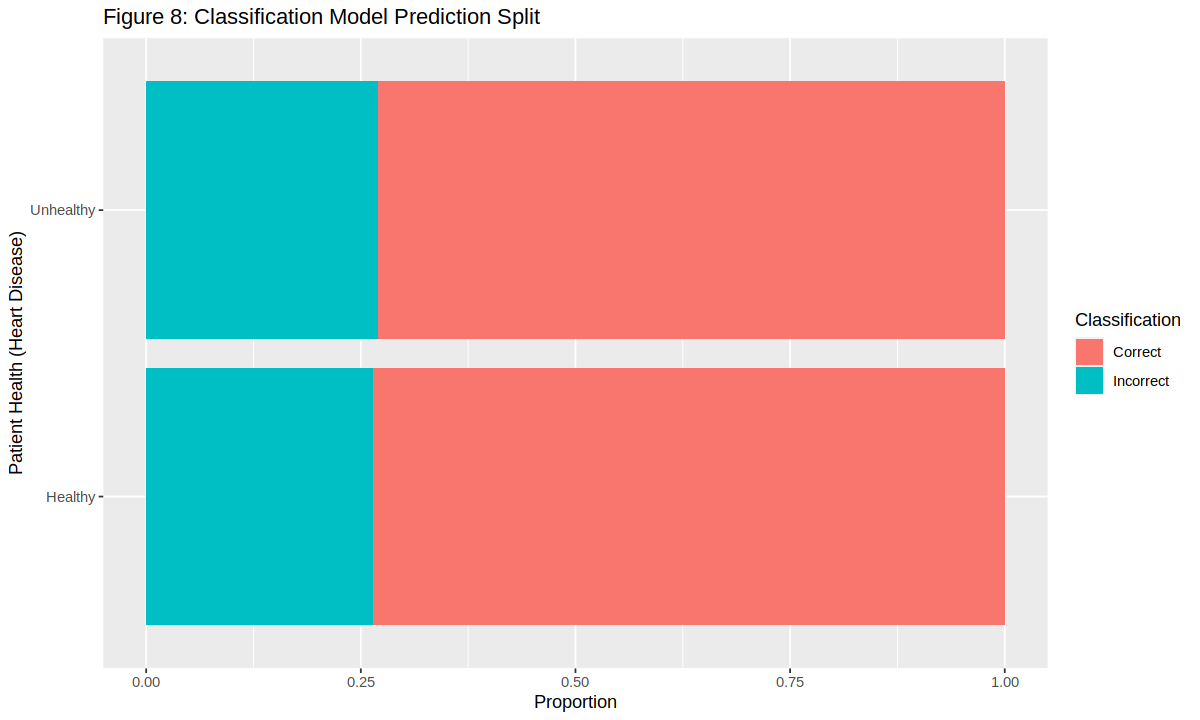

In [79]:
options(repr.plot.height = 6, repr.plot.width = 10)
split_plot <- ggplot(result_tibble, aes(y = result, fill = classification)) + 
    geom_bar(position = "fill") + 
    labs(y = "Patient Health (Heart Disease)", x = "Proportion", title = "Figure 8: Classification Model Prediction Split", fill = "Classification")
split_plot

In figure 8 the split between correct and incorrect classifications is expressed through a ratio bar plot for both possible classifications and was plotted horizontally to create a more effective visualization, to make it easier to spot the difference in their respective proportions even though the difference is minuscule. It's evident that the classification for both categories is just under 75%, aligning with our accuracy of 73.3%. This plot tells us that our model is not biased towards one classification category over another and expresses a somewhat equal weightage for both classifications.

### Discussion

**Summary:**

Using the classification model we created, we were able to predict within 73.3% accuracy whether a patient was at risk of heart failure (Unhealthy) or not (Healthy), using the metrics of their age, blood pressure, cholesterol level, and maximum heart rate. From figure 1, we found that there is a slightly negative relationship between the age and the maximum heart rate of an individual. We also found in figure 2 that there is a slightly negative relationship between the maximum heart rate and the cholesterol level and a slightly positive relationship between the age and resting systolic blood pressure of a patient.

In short, our findings were as expected and mentioned in the introduction, that older individuals with increased resting blood pressure, increased cholesterol levels, and decreased maximum heart rate tend to have an unhealthier heart leading to an increased risk of heart failure in their life. These are the results we expected and also align with the literature which states that high blood pressure and cholesterol are leading factors for people at risk of heart failure (CDC.gov, 2022). 

**Initial Question:** Can we predict whether a patient will experience heart failure (caused by heart disease) based on their age, resting blood pressure, cholesterol, and maximum heart rate?

**Answer:** Yes, to an extent we can predict whether a patient will experience heart failure based on the factors listed in the questions. However, we only get a 73.3% accuracy if these factors are used to create a classification model to create these predictions. We get some success using this solution to answer our predictive question, but we believe there are some changes we could have made to our model in order to increase our accuracy and create a model with plausible applications such as usage in a hospital.

**Improvements:** In order to improve our model we could have attempted to change a number of things about our entire report. The main improvement being that we increase the population data size. If we were to increase the dataset by accessing heart disease data from multiple different hospitals we could possibly see an increase in our model's testing accuracy possibly also making it more versatile. To increase accuracy we may have also have to re-evaluate the factors used to make our model. It may be possible that some of the factors used in the recipe may be unrelated to heart disease classification and show trends due to other underlying health reasons. Furthermore, there may have been better factors which would show larger correlation with heart disease, however, weren't chosen for our analysis in order to make this model more manageable. All in all, a 73.3% accuracy is not horrible, but there are improvements which we are able to make in order to make this model more accurate.

**Impact:**  We hope that our findings could help medical operators and other individuals trying to assess patient health. Our model acts as a simple precaution any individual who might be at risk of heart failure could take to asses themselves with the circumstances that we have given above. This does show that while the above 70% accuracy is acceptable, however, it is definitely not perfect and there is a chance that a patient gets misdiagnosed but it would still be of help to diagnose the majority population of heart disease patients. If our model was used in the field it would have to be used with numerous other tests and biological methods of finding out if a patient has heart disease because although the model is accurate for a majority of patients it will theoretically incorrectly classify about 1 in every 4 patients, so using it amongst other testings in a hospital would be the best use of our model.

**Future Questions:**
* Would changing its factors be a more accurate way of predicting an individual’s risk of heart failure? If not, how could we make our model more accurate?
* Could our model help predict other health concerns with other organs like lungs, liver, kidney, etc.?
* How versatile is this model? Will it be just as accurate on individual's from a different demographic?


### Citations

Fedesoriano. (2021, September 10). *Heart failure prediction dataset*. Kaggle. 
>https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

CDC.gov. (2022, September 8). *Heart disease and stroke*. Centers for Disease Control and Prevention. 
>https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart,unhealthy%20diet%2C%20and%20physical%20inactivity 
    
Reule, S., &amp; Drawz, P. E. (2012, December). *Heart rate and blood pressure: Any possible implications for management of hypertension?*. Current hypertension reports.
>https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3491126/#:~:text=The%20relationship%20between%20heart%20rate%20and%20blood%20pressure%20is%20location,rate%20and%20central%20blood%20pressures 